# ML Enablement Workshop: 顧客離反分析シナリオ クラウド活用編

## コンテンツ

1. 背景
1. 環境構築
1. 学習をスケールする
1. モデルをホスティングする
   1. 性能評価
   1. エンドポイントの削除
1. Notebookを移行する

---

## 1.背景

顧客離反分析を行う際に、Studio Labでは機能的・コンピューティングリソース的に不十分な状況に直面することがあるでしょう。例えば、データ量が多くなるほど高精度なモデルが期待できますがその分学習に時間がかかります。また、学習したモデルを検証するためにAPI経由で利用可能にする必要があることもあります。本Notebookでは、機械学習の価値検証で追加の機能・コンピューティングリソースが必要になったときにAmazon SageMakerを使う方法を解説します。API経由での機能の呼び出しだけでなく、NotebookごとSageMakerへ移行する方法についても解説します。

---

## 2.環境構築

Conda を使った環境構築の手順は本シナリオと同じため、先に [customer_churn.ipynb](./customer_churn.ipynb) を参照し環境構築を行ってください。
Jupyter Notebookの右上にある虫の隣のボタンをクリックしカーネルを切り替えます。

![environment_setup_002.Ppng](./images/002.png)

### 2-2. AWS アクセスのセットアップ

以下を参考にご自身の AWS 環境にアクセスできるようにします。
- https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/studio-lab-use-external.html#studio-lab-use-external-s3
- https://github.com/aws/studio-lab-examples/blob/main/connect-to-aws/Access_AWS_from_Studio_Lab.ipynb

初めに、SageMakerTrainingJob の実行権限・表示権限を持つ IAM ユーザーを作成します。本ハンズオンでは簡易化のため IAM ユーザーの作成の際に、以下のポリシーを付与します。本番環境で実行する際は、必要最小権限にする必要があります。
- PowerUserAccess
- AmazonSageMakerFullAccess

名前は任意ですが、以降では`sagemaker-studio-lab-access`として扱います。 IAM ユーザー作成時の最後のページで取得できるアクセスキーとシークレットアークセスキーをメモにコピーします。 *クレデンシャル情報の取り扱いには注意してください。

続いて、Terminalを起動します。

![environment_setup__optional_001.png](./images/optional_001.png)

ターミナル内で以下のコマンド実行します。
```
aws configure
```

アクセスキー ID とシークレットアクセスキーは先にメモをした内容を貼り付けます。リージョンには`ap-northeast-1`を入力し、アウトプットフォーマットは空のままエンターを押します。
![environment_setup__optional_002.png](./images/optional_002.png)


### 2-3. SageMaker Training Instance が利用する IAM ロールを作成する

以下を参考に IAM ロールを作成します。
- https://docs.aws.amazon.com/ja_jp/glue/latest/dg/create-an-iam-role-sagemaker-notebook.html

IAM ロールの作成の際に、以下のポリシーを付与されていることを確認します。
- AmazonSageMakerFullAccess

名前は任意ですが、以降では`SageMakerStudioLabExecuteRole`として扱います。 

![environment_setup_optional_003.png](./images/optional_003.png)
作成した IAM ロールの ARN をコピーし、以下のセルに入力します。マネジメントコンソールで IAM ロールから確認できます。

以降で利用するライブラリをここで読み込んでおきます。

In [15]:
# Define IAM role
from pathlib import Path
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data_root = Path("../../data/")
role = "arn:aws:iam::000000000000:role/SageMakerStudioLabExecuteRole"

---
## 3.学習をスケールする

学習を始める前に、学習データをAmazon S3にアップロードしSageMakerから利用できるようにします。

In [ ]:
sagemaker_session = sagemaker.Session()
input_train = sagemaker_session.upload_data(path=str(data_root.joinpath('interim/churn_train.csv')), key_prefix='sagemaker/DEMO-xgboost-churn')
input_validation = sagemaker_session.upload_data(path=str(data_root.joinpath('interim/churn_validation.csv')), key_prefix='sagemaker/DEMO-xgboost-churn')

`input_train` と `input_validation` にはアップロードしたファイルのS3パスが保存されています。これらは csv ファイルですが、Amazon SageMaker が用意している XGBoost のコンテナは、ファイルをデフォルトで libsvm 形式と認識してしまうため、このままだとエラーが発生します。
`TrainingInput`という関数を利用して、`content_type='text/csv'`を明示的に指定することで、csv 形式と認識させることができます。

csv は以下のようなデータである必要がありますが、先の前処理の段階でこのようなデータ形式に変換しているため、追加の処理は必要ありません。

- 1列目が予測対象のデータ
- ヘッダ行はなし

In [16]:
# from sagemaker.session import s3_input
from sagemaker.inputs import TrainingInput

content_type='text/csv'
s3_input_train = TrainingInput(input_train, content_type=content_type)
s3_input_validation = TrainingInput(input_validation, content_type=content_type)

Amazon SageMaker は、マネージドで、分散学習が設定済みで、リアルタイム推論のためのホスティングも可能な XGBoost コンテナを用意しています。

In [6]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")

それでは学習を始めましょう。まず、XGBoost のコンテナの場所を取得します。コンテナ自体は SageMaker 側で用意されているので、場所を指定すれば利用可能です。学習のためにハイパーパラメータを指定したり、学習のインスタンスの数やタイプを指定することができます。XGBoost における主要なハイパーパラメータは以下のとおりです。

- `max_depth` アルゴリズムが構築する木の深さをコントロールします。深い木はより学習データに適合しますが、計算も多く必要で、overfiting になる可能性があります。たくさんの浅い木を利用するか、少数の深い木を利用するか、モデルの性能という面ではトレードオフがあります。
- `subsample` 学習データのサンプリングをコントロールします。これは overfitting のリスクを減らしますが、小さすぎるとモデルのデータが不足してしまいます。
-  `num_round` ブースティングを行う回数をコントロールします。以前のイテレーションで学習したときの残差を、以降のモデルにどこまで利用するかどうかを決定します。多くの回数を指定すると学習データに適合しますが、計算も多く必要で、overfiting になる可能性があります。
- `eta` 各ブースティングの影響の大きさを表します。大きい値は保守的なブースティングを行います。
- `gamma` ツリーの成長の度合いをコントロールします。大きい値はより保守的なモデルを生成します。

XGBoostのhyperparameterに関する詳細は [github](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst) もチェックしてください。

In [7]:
sess = sagemaker.Session()

hyperparameters = {"max_depth":"5",
                        "eta":"0.2",
                        "gamma":"4",
                        "min_child_weight":"6",
                        "subsample":"0.8",
                        "objective":"binary:logistic",
                        "num_round":"100"}

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    hyperparameters=hyperparameters,
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    sagemaker_session=sess)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2022-09-06 05:31:27 Starting - Starting the training job...
2022-09-06 05:31:53 Starting - Preparing the instances for trainingProfilerReport-1662442286: InProgress
.........
2022-09-06 05:33:16 Downloading - Downloading input data......
2022-09-06 05:34:12 Training - Downloading the training image......
2022-09-06 05:35:17 Training - Training image download completed. Training in progress.[2022-09-06 05:35:21.642 ip-10-0-188-111.ap-northeast-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:

---
## 4.モデルをホスティングする

学習が終われば、`deploy()`を実行することで、エンドポイントを作成してモデルをデプロイできます。

In [8]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

-------!

### 4-1.性能評価

現在、エンドポイントをホストしている状態で、これを利用して簡単に予測を行うことができます。予測は http の POST の request を送るだけです。
ここではデータを `numpy` の `array` の形式で送って、予測を得られるようにしたいと思います。しかし、endpoint は `numpy` の `array` を受け取ることはできません。

このために、`csv_serializer` を利用して、csv 形式に変換して送ることができます。

In [9]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

先のノートブックで作成済みのテストデータを受け取ると、これをデフォルト500行ずつのデータにわけて、エンドポイントに送信する `predict` という関数を用意します。あとは `predict` を実行して予測結果を受け取ります。 

In [10]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

test_data = pd.read_csv('test.csv', header=None)
dtest = test_data.values
predictions = []
predictions.append(predict(dtest[:, 1:]))
predictions = np.array(predictions).squeeze()

機械学習の性能を比較評価する方法はいくつかありますが、単純に、予測値と実際の値を比較しましょう。今回は、顧客が離反する `1` と離反しない `0` を予測しますので、この混同行列を作成します。

In [11]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,235,18
1,11,236


_注意点, アルゴリズムにはランダムな要素があるので結果は必ずしも一致しません._

48人の離反者がいて、それらの39名 (true positives) を正しく予測できました。そして、4名の顧客は離反すると予測しましたが、離反していません (false positives)。9名の顧客は離反しないと予測したにもかかわらず離反してしまいました (false negatives)。

重要な点として、離反するかどうかを `np.round()` という関数で、しきい値0.5で判断しています。`xgboost` が出力する値は0から1までの連続値で、それらを離反する `1` と 離反しない `0` に分類します。しかし、その連続値 (離反する確率) が示すよりも、顧客の離反というのは損害の大きい問題です。つまり離反する確率が低い顧客も、しきい値を0.5から下げて、離反するとみなす必要があるかもしれません。もちろんこては、false positives （離反すると予測したけど離反しなかった）を増やすと思いますが、 true positives (離反すると予測して離反した) を増やし、false negatives (離反しないと予測して離反した）を減らせます。

直感的な理解のため、予測結果の連続値をみてみましょう。

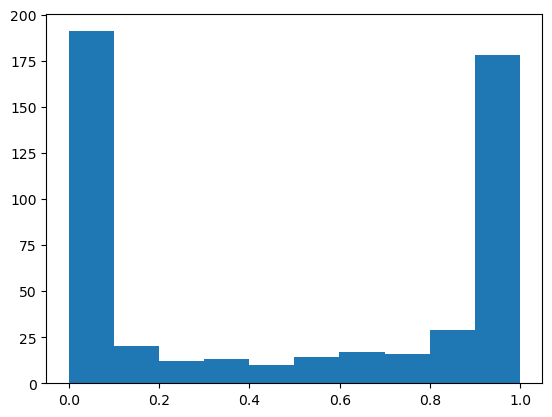

In [12]:
plt.hist(predictions)
plt.show()

連続値は0から1まで歪んでいますが、0.1から0.9までの間で、しきい値を調整するにはちょうど良さそうです。

In [13]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
0,,
0,221,32
1,2,245


### 4-2. エンドポイントの削除

SageMaker 推論エンドポイントは起動したままだとコストがかかります。不要な場合は削除します。

In [14]:
xgb_predictor.delete_endpoint()

---
## 5. Notebook を移行する

社内のデータを扱う場合、 Studio Lab ではセキュリティが気になることがあるかもしれません。 Studio Lab から SageMaker Studio へ移行することで、データやネットワークのセキュリティを自社のセキュリティ基準に合わせて構築することができます。 SageMaker Studio へ移行することで、 Data Wrangler や SageMaker Pipeline を使用して Studio Lab では難しい規模のデータ処理ワークフローを構築することもできます。 SageMaker Studio は、 Studio Lab のエンタープライズ版とイメージ頂くとよいと思います。ほぼ同じインタフェースで、Studio Lab にはない機能の利用、高パフォーマンスのインスタンスでの Notebook の実行ができます。

![optional_004.png](images/optional_004.png)

Studio Lab から SageMaker Studio へ移行する方法は [Export Amazon SageMaker Studio Lab environment to Amazon SageMaker Studio](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/studio-lab-use-migrate.html) で紹介されていますが、端的には Git リポジトリを経由して簡単に移行することができます。本節ではその手順を解説します。

### SageMaker Studio Domain を作成する。

移行先の SageMaker Studio 環境を作成します。 SageMaker Studio の特徴は、1) JupyterLab のUIを提供するアプリケーションサーバー、2) ノートブックを実行するコンピューティングインスタンス、3) データを保管するボリュームが疎結合になっていることです。1, 2, 3をまとめたアーキテクチャを **SageMaker Studio Domain** と呼んでいます。

![optional_005.png](images/optional_005.png)

今回は SageMaker Studio Domain を作成済みとして、 SageMaker Studio を開いたところからスタートします。

### SageMaker StudioにNotebookを移行する

はじめに GitHub からリポジトリを clone します。 Studio Lab と同じように Git の拡張がインストールされているので拡張を使用し簡単に clone することができます。

![optional_006.png](images/optional_006.png)

clone が終了したら、 Notebook を実行するための環境を作成します。 Notebook を実行するためのインスタンスを Launcher から起動します。今回は Conda があらかじめインストールされている `Data Science 2.0` を選択します。 

![optional_007.png](images/optional_007.png)

起動した`Image Terminal` は、 Notebook を実行するインスタンスのターミナルになります。はじめに clone を実行したサーバーは JupyterLab のサーバーでしたが、 Notebook のインスタンスでも clone したファイルを参照することができます。これは、 EFS でファイルを共有しているためです。

![optional_008.png](images/optional_008.png)

`Image Terminal` で実行するコマンドは次の 3 つです。`notebooks/scenario_churn`のフォルダに移動して実行します。Studio Lab では右クリックだけで Conda の環境が作成できましたが、 Studio にはその機能がないため `Image Terminal` でコマンドを使い環境を作成します。

1. `conda env create -f environment.yml`
2. `conda activate ml-handson-churn`
3. `ipython kernel install --name ml-handson-churn --user`

1 番目のコマンドで環境を作成し、 2 番目のコマンドで作成した `ml-handson-churn` の環境を有効化し 3 番目のコマンドで Notebook から作成した環境が使えるようにしています。

![optional_009.png](images/optional_009.png)

全てのコマンドが実行した後、 Notebook を開きます。すると、 Notebook から作成した Kernel が選べるようになっています。

![optional_010.png](images/optional_010.png)

後の実行方法は Studio Lab と同じです。

### SageMaker Studio と Studio Lab の違い

SageMaker Studio では Notebook を実行するために専用のインスタンスを立ち上げました。立ち上げているインスタンスは左側のメニューから確認できます。

![optional_011.png](images/optional_011.png)

インスタンスの起動時間に応じて料金がかかりますので、 Notebook の実行が終わったら停止をしておきましょう。停止して再度インスタンスを立ち上げるときは、新しいインスタンスであるため再度セットアップが必要です。 Studio Lab に比べて手間がかかる点です。起動に手間がかかりますが、必要に応じてインスタンスタイプを変えたり複数のインスタンスで Notebook を並行で実行するなど、クラウドならではのスケーラビリティを活かすことができます。

![optional_012.png](images/optional_012.png)

GPU インスタンス起動時にエラーが発生する場合、 GPU インスタンスが起動できる上限が 0 になっている可能性があります。 AWS マネジメントコンソールの EC2 の画面から、制限を選択し必要な分を上限緩和申請してください。

![optional_013.png](images/optional_013.png)